In [1]:
import os
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset import Dataset
from pipeline import Pipeline
from visualizations import Visualizer
#controling whether tensorflow does recognize GPU
tf.config.get_visible_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#Load dataset
data = Dataset.get_btc_data()

In [3]:
#Inititate processing pipeline
pipeline = Pipeline(crypto_tick = "btc")
#Initiate visualizer
visualizer = Visualizer()

In [6]:
print("Missing values distribution:")
visualizer.get_missing_columns(data = pipeline.data)

Missing values distribution:


{'BTC / Capitalization, market, estimated supply, USD': [3092, '% 70.594'],
 'BTC / Volatility, daily returns, 180d': [11, '% 0.251'],
 'Wiki_btc_search': [1640, '% 37.443'],
 'Close_^DJI': [1360, '% 31.05'],
 'Close_^GSPC': [1360, '% 31.05'],
 'Close_GC=F': [1363, '% 31.119'],
 'Close_^VIX': [1360, '% 31.05'],
 'Close_^IXIC': [1360, '% 31.05'],
 'Close_SMH': [1360, '% 31.05'],
 'Close_VGT': [1360, '% 31.05'],
 'Close_XSD': [1360, '% 31.05'],
 'Close_IYW': [1360, '% 31.05'],
 'Close_FTEC': [2067, '% 47.192'],
 'Close_IGV': [1360, '% 31.05'],
 'Close_QQQ': [1360, '% 31.05'],
 'Wiki_crypto_search': [1640, '% 37.443'],
 'USD_EUR_rate': [161, '% 3.676'],
 'BTC-USD': [1353, '% 30.89']}

/tmp/ipykernel_114519/523243249.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


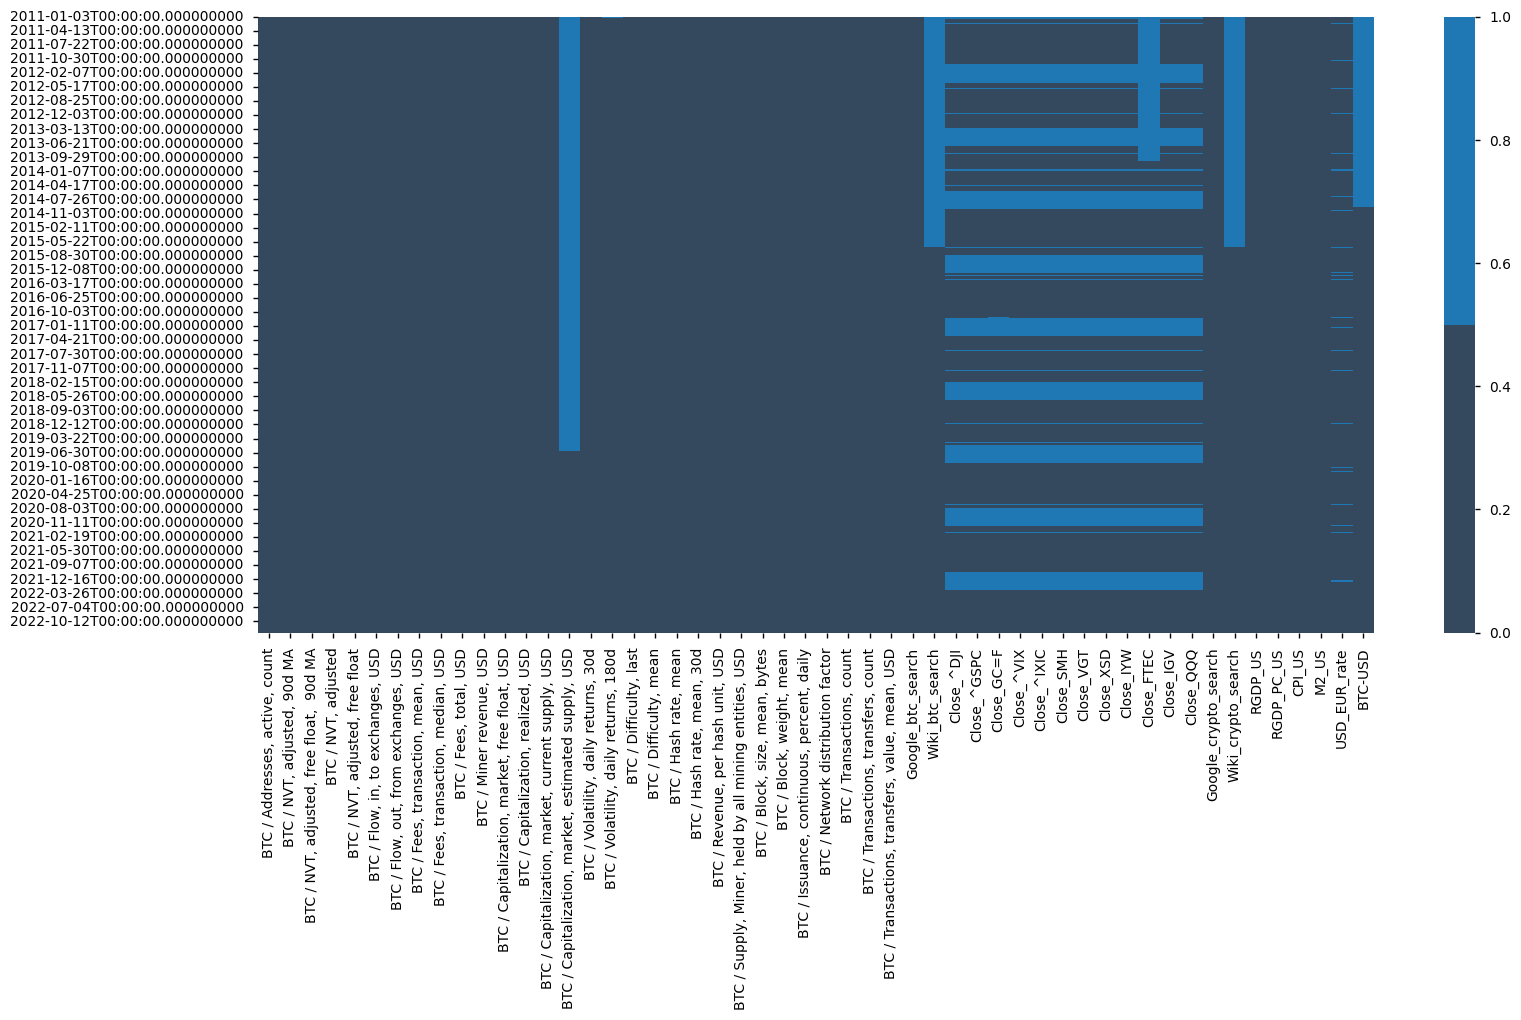

In [7]:
fig = visualizer.draw_missing_data(data = pipeline.data)
fig.show()

In [8]:
pipeline.set_beginning(start_date = "2014-9-17")

/tmp/ipykernel_114519/523243249.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


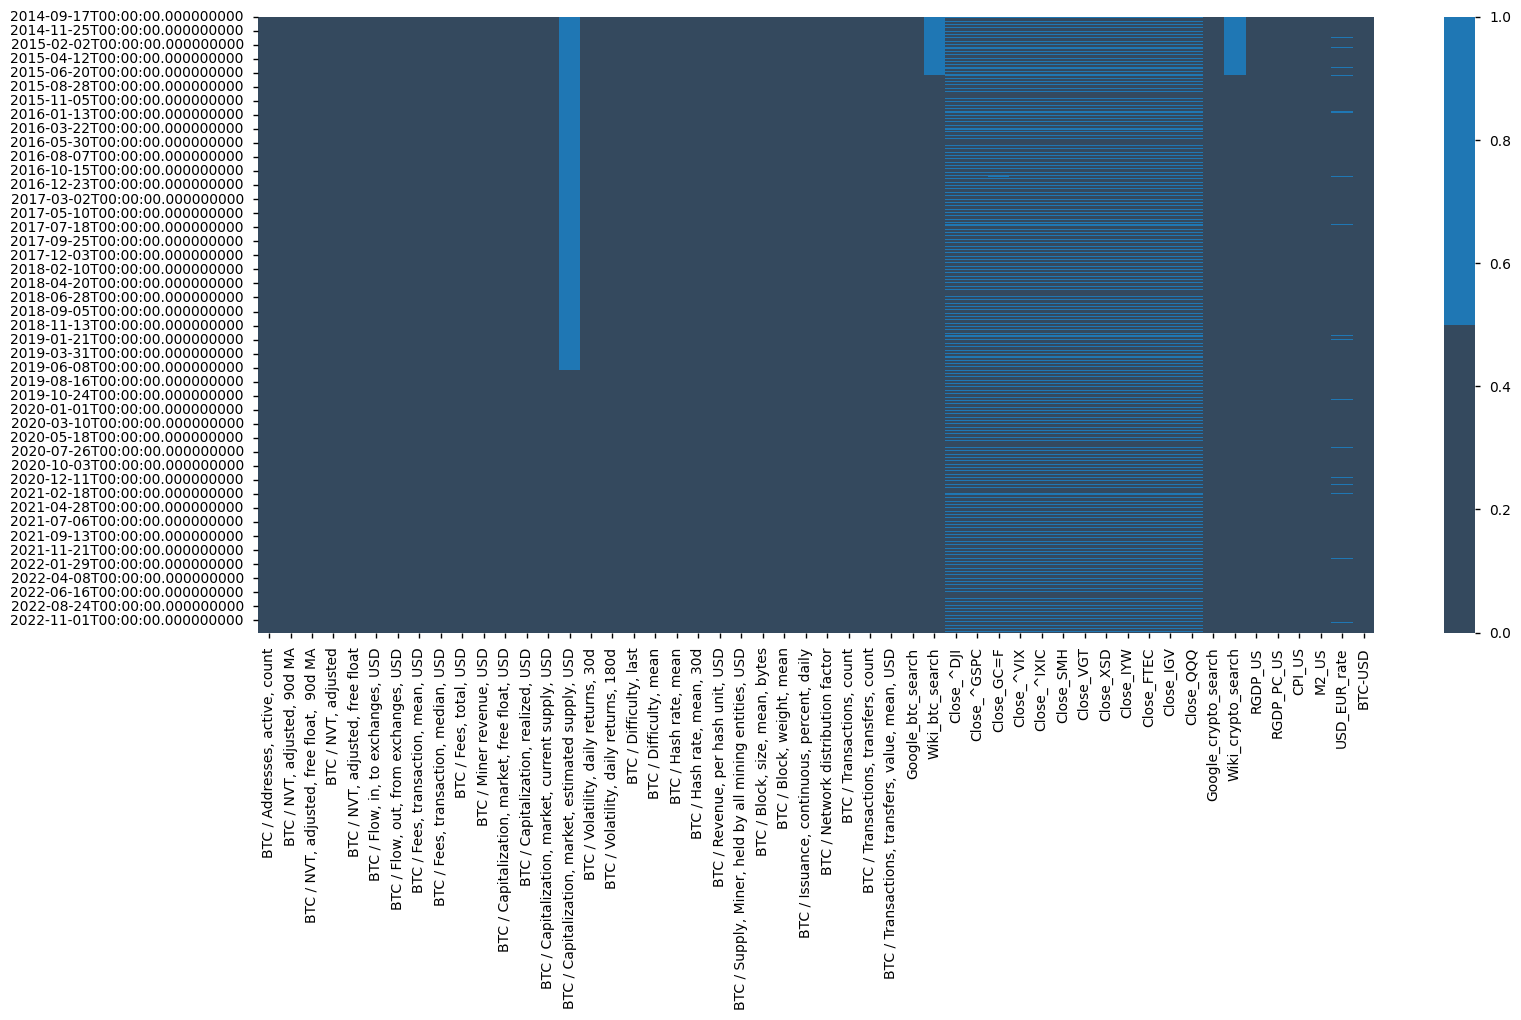

In [9]:
fig = visualizer.draw_missing_data(data = pipeline.data)
fig.show()

In [10]:
pipeline.preprocess_dataset()

/tmp/ipykernel_114519/523243249.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


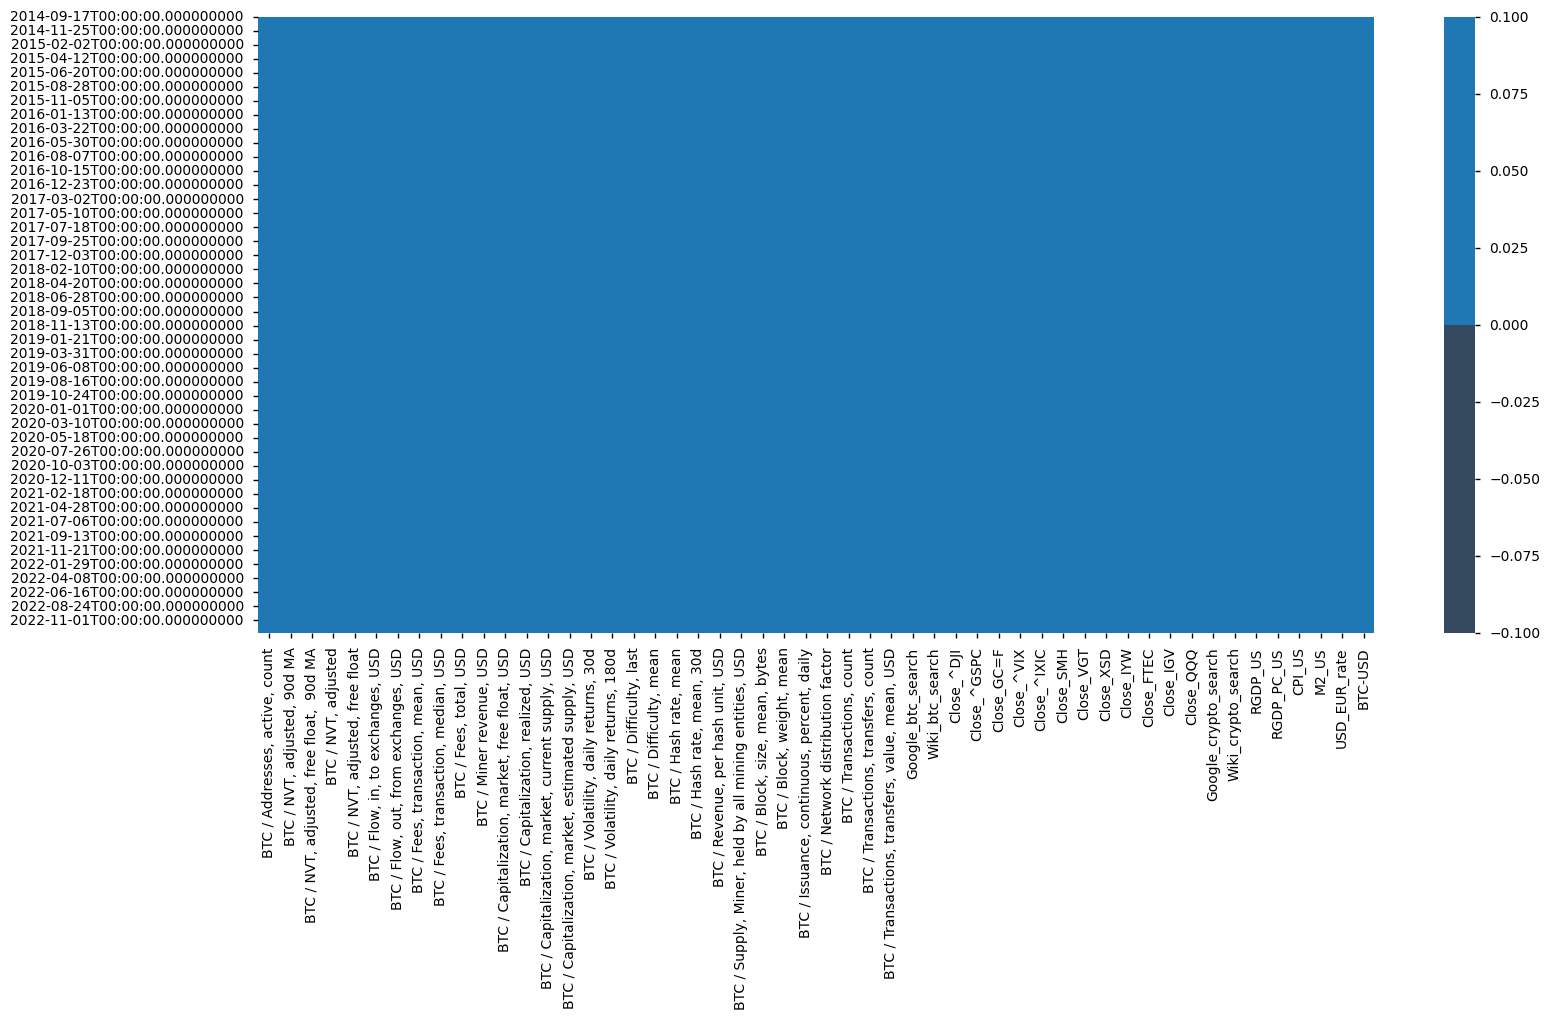

In [11]:
fig = visualizer.draw_missing_data(data = pipeline.data)
fig.show()

In [ ]:
pipeline.shift_target()